In [1]:
import os
import glob
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
from numpy.linalg import norm as lnorm
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
sns.set_context('talk')

# Lihui's behavioral data

In [3]:
datadir = '/Users/Oliver/Desktop/Lihui_Data/RI/Exp2'

In [4]:
test_data = pd.read_hdf(pjoin(datadir, 'sub-001_ver1_sess1_Naming.hdf'))
test_data.head()

,Img,ImgName,AlterNames,Answer,Choice,RT,MousePos,Block,Trlnum
0,stim_set/Loeffel.6_v2_percept.png,Löffel,"[Schere, Zahnpasta, Glas]",0,3,2.481411,"[-0.4635416666666667, -0.2111111111111111]",0,0
1,stim_set/Glas.3_v2_percept.png,Glas,"[Schere, Tasse, Flasche]",0,99,0.000000,"[-0.39375, -0.24444444444444444]",0,1
2,stim_set/Flasche.2_v2_percept.png,Flasche,"[Tasse, Banane, Schere]",0,99,0.000000,"[-0.5552083333333333, -0.23148148148148148]",0,2
3,stim_set/Flasche.3_v2_percept.png,Flasche,"[Glas, Schere, Apfel]",0,3,2.212549,"[0.5010416666666667, -0.22037037037037038]",0,3
4,stim_set/Schere.2_v2_percept.png,Schere,"[Zahnpasta, Flasche, Glas]",0,3,2.833762,"[-0.22291666666666668, -0.22407407407407406]",0,4


Take the results from the second experiment, naming task.

# Compute Euclidean Distance between original and simulation

In [5]:
def comp_ed(sim_hmax, orig_hmax):
    """
    Read HMAX output files for simulated and original image with pandas.
    Compute Euclidean distance between the two.
    Return dict with ED, as well as file paths
    """
    # simulated
    sim_df = pd.read_csv(sim_hmax, header=None)
    assert np.shape(sim_df[0]) == (2000,)

    # original
    orig_df = pd.read_csv(orig_hmax, header=None)
    assert np.shape(orig_df[0]) == (2000,)

    # compute euclidean distance
    ed = lnorm(sim_df[0]-orig_df[0])

    # get path names of pictures
    orig_pname = orig_hmax.replace('.ascii', '').replace('./results/', '')
    sim_pname = sim_hmax.replace('.ascii', '').replace('./results/', '')
    
    # return dict
    ed_dict = {
        'ed' : ed,
        'orig' : orig_pname,
        'sim' : sim_pname
    }
    return ed_dict

In [6]:
# Example

ed_dict = comp_ed(sim_hmax='./results/Apfel.1_v2_percept.png.ascii',
             orig_hmax='./results/Apfel.1_v1_new.jpg.ascii')

print(ed_dict)

{'ed': 8.966686528324578, 'sim': 'Apfel.1_v2_percept.png', 'orig': 'Apfel.1_v1_new.jpg'}


## Collect EDs for all relevant stimuli

In [7]:
# how many HMAX outputs have we?
# Should be 144 (80 originals + 64 simulations used by Lihui)
assert len(glob.glob('./results/*')) == 144

In [8]:
# My HMAX output
sim_flist = glob.glob('./results/*')
sim_flist.sort()
# sim_flist

In [9]:
# Names of Lihui's stimuli without file extension
picnames = [pathname.split('/')[-1].replace('_v2_percept.png','') for pathname in test_data.Img.unique()]
#picnames

In [10]:
# iterate through all relevant stimuli

# list of dicts to be filled
ed_dicts = []

for picname in picnames:
    # paths to hmax results
    orig_hmax = './results/' + picname + '_v1_new.jpg.ascii'
    sim_hmax = './results/' + picname + '_v2_percept.png.ascii'
    # ed
    ed_dict = comp_ed(sim_hmax, orig_hmax)
    ed_dicts.append(ed_dict)

assert len(ed_dicts) == 64

## Descriptive statistics

In [11]:
# only the distances
eds = [ed_dict['ed'] for ed_dict in ed_dicts]

In [12]:
print('mean ED: %f' % np.mean(eds))
print('standard deviation: %f' % np.std(eds))

mean ED: 15.477273
standard deviation: 1.607819


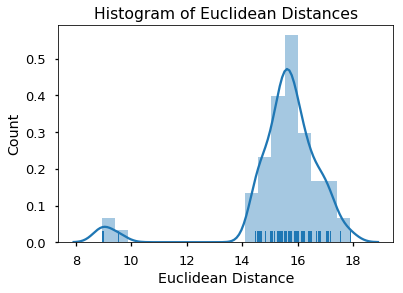

In [13]:
sns.distplot(eds, rug=True)

plt.title('Histogram of Euclidean Distances')
plt.xlabel('Euclidean Distance')
plt.ylabel('Count')

**Note:**
- Euclidean distances are not normally distributed due to some outliers with low values (these could be apples)
- Besides that, there seems to be enough variability in the EDs to use for prediction

## Find the outliers

In [14]:
sorted_ed_dicts = sorted(ed_dicts, key=lambda k: k['ed']) 

In [16]:
sorted_ed_dicts[:5]

[{'ed': 8.941344299468149,
  'orig': 'Apfel.2_v1_new.jpg',
  'sim': 'Apfel.2_v2_percept.png'},
 {'ed': 8.966686528324578,
  'orig': 'Apfel.1_v1_new.jpg',
  'sim': 'Apfel.1_v2_percept.png'},
 {'ed': 9.52822620953396,
  'orig': 'Apfel.3_v1_new.jpg',
  'sim': 'Apfel.3_v2_percept.png'},
 {'ed': 14.448208366549999,
  'orig': 'Apfel.7_v1_new.jpg',
  'sim': 'Apfel.7_v2_percept.png'},
 {'ed': 14.517777719989972,
  'orig': 'Loeffel.6_v1_new.jpg',
  'sim': 'Loeffel.6_v2_percept.png'}]

The three outliers are indeed some of the apples.